In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split,GridSearchCV
import numpy as np
import matplotlib.pyplot as plt 
#import skimage
import rasterio
from sklearn.metrics import accuracy_score
import torch
from sklearn.preprocessing import StandardScaler
import os
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
import tensorflow as tf

In [7]:
#!pip install scikit-image
#!pip3 install torch torchvision torchaudio
#!pip install varname
#!pip install keras
#!pip install tensorflow

In [8]:
#ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [55]:
#feature image path
feature_img_path = "E:/Grss_data/Track1/train/images/142.tif"
# Load the feature tif image with multibands
with rasterio.open(feature_img_path) as src:
    feature_img = src.read()
#check if the image is loaded
if feature_img is None:
    print("Error: Image not found")
else:
    print('Feature image size: {}'.format(feature_img.shape))

#load the label image
label_img_path = "E:/Grss_data/Track1/train/labels/142.png"
#load the label image
with rasterio.open(label_img_path) as src:
    label_img = src.read()
#check if the image is loaded
if label_img is None:
    print("Error: Image not found")
else:
    print('Feature image size: {}'.format(label_img.shape))


Feature image size: (6, 512, 512)
Feature image size: (1, 512, 512)


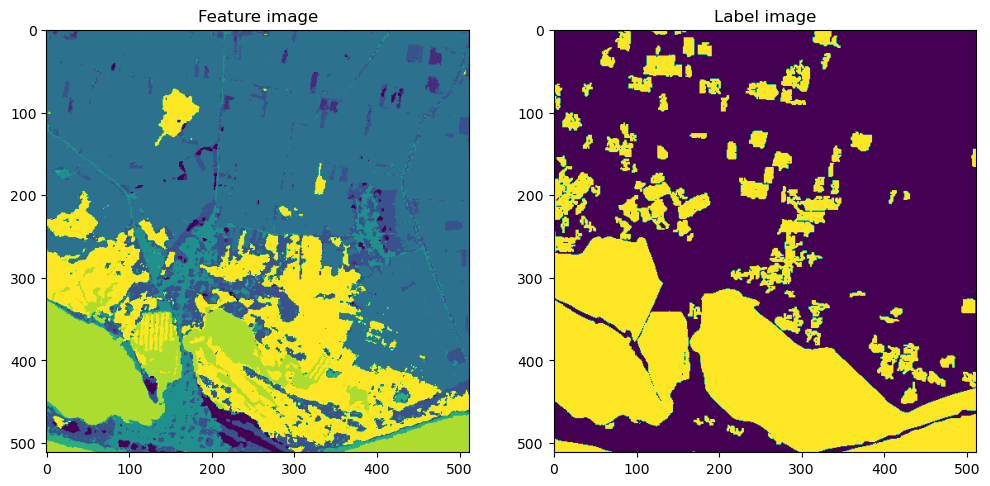

In [56]:
#display the image and label image side by side
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 8))
ax1.imshow(feature_img[4])
ax1.set_title('Feature image')
ax2.imshow(label_img[0])
ax2.set_title('Label image')
plt.show()


In [57]:
#check -9999  values in each band of the feature image
for i in range(feature_img.shape[0]):
    print('Band {} has {} no data values'.format(i, np.sum(feature_img[i]==-9999)))

Band 0 has 0 no data values
Band 1 has 0 no data values
Band 2 has 15644 no data values
Band 3 has 0 no data values
Band 4 has 0 no data values
Band 5 has 0 no data values


In [58]:
#set -9999 values to 0
feature_img[feature_img==-9999] = 0

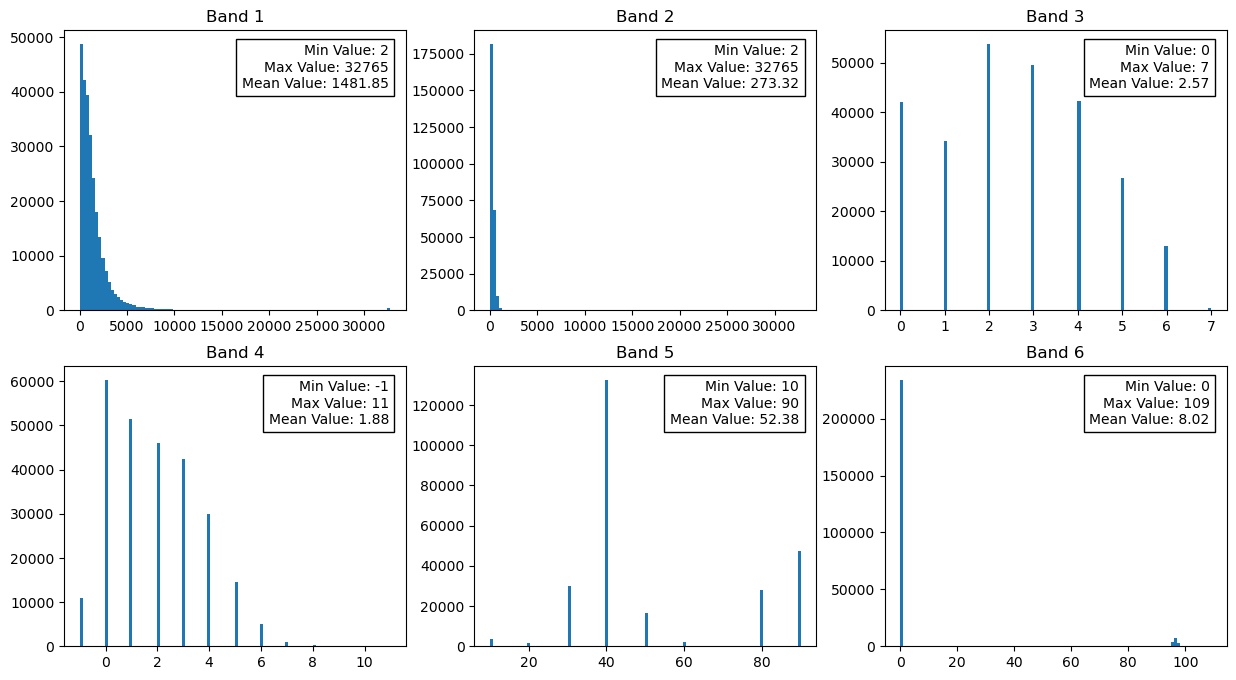

In [59]:
#plot the distribution of the features image.
plt.figure(figsize=(15,8))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.hist(feature_img[i].ravel(), bins=100)
    plt.title("Band {}".format(i+1))
    plt.text(0.95, 0.95, "Min Value: {}".format(np.min(feature_img[i]))+'\n'+"Max Value: {}".format(np.max(feature_img[i]))+'\n'+"Mean Value: {}".format(round(np.mean(feature_img[i]),2)), ha='right', va='top', transform=plt.gca().transAxes,bbox=dict(facecolor = 'none',edgecolor = 'black'))

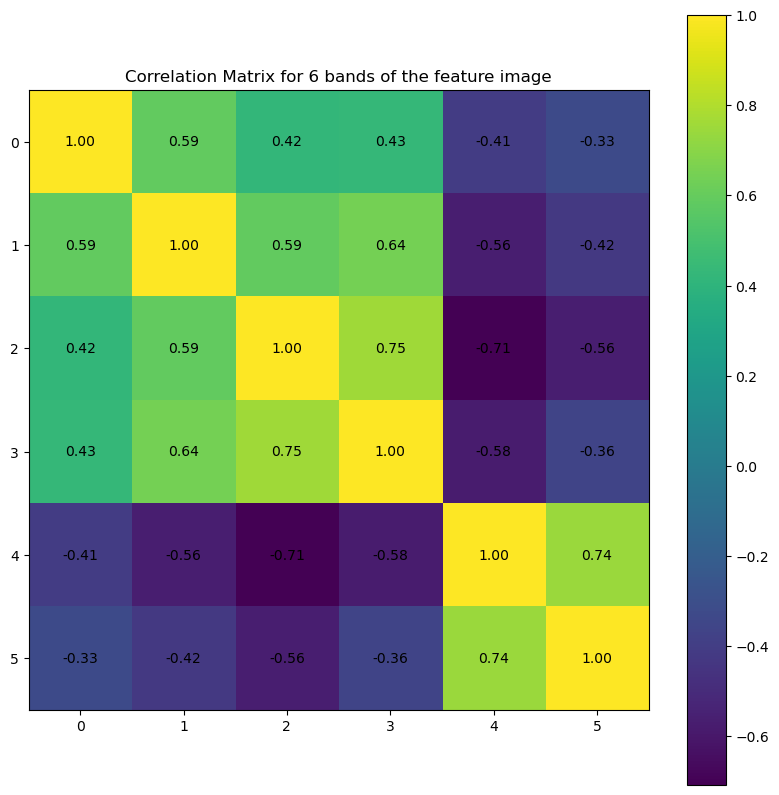

In [41]:
# Calculate the correlation matrix
corr_matrix = np.corrcoef(feature_img.reshape(6, -1), rowvar=True)

# Set up the figure
plt.figure(figsize=(10, 10))

# Display the correlation matrix
cax = plt.imshow(corr_matrix, interpolation='nearest')
plt.colorbar(cax)

# Add title
plt.title("Correlation Matrix for 6 bands of the feature image")

# Adding the correlation values as text annotations
for i in range(len(corr_matrix)):
    for j in range(len(corr_matrix)):
        plt.text(j, i, f'{corr_matrix[i, j]:.2f}', ha='center', va='center', color='black')

# Show the plot
plt.show()

In [10]:
feature_img

array([[[1005, 1239,  892, ..., 3331, 2943, 1682],
        [ 804, 1069,  804, ..., 2365, 2943, 3124],
        [1193,  776,  504, ..., 1549, 3702, 5603],
        ...,
        [ 821,  598,  355, ..., 1666, 1100,  711],
        [ 920, 1179,  632, ..., 1494, 1014,  306],
        [ 666,  755, 1046, ..., 2541, 1308,  306]],

       [[  96,   74,  135, ...,  511,  496,   96],
        [  71,   38,   64, ...,  330,  496,  389],
        [ 200,  131,  107, ...,  115,  362,  402],
        ...,
        [ 322,  322,   64, ...,  280,  204,  143],
        [ 353,  493,  199, ...,  235,  156,  209],
        [ 246,  373,  464, ...,  286,  130,  209]],

       [[  19,   19,   19, ...,   21,   21,   21],
        [  19,   19,   19, ...,   21,   21,   21],
        [  19,   19,   19, ...,   21,   21,   21],
        ...,
        [  73,   73,   73, ...,   45,   45,   45],
        [  73,   73,   74, ...,   45,   45,   45],
        [  73,   74,   74, ...,   45,   45,   45]],

       [[  18,   18,   18, ...,   18,

In [11]:
#re-orgnize the feature image, so that the image can be used for training
feature_img = np.moveaxis(feature_img, 0, -1)
feature_img = feature_img.reshape(-1, 6)
label_img = label_img.reshape(-1)

In [12]:
feature_img

array([[1005,   96,   19,   18,   30,    0],
       [1239,   74,   19,   18,   30,    0],
       [ 892,  135,   19,   18,   30,    0],
       ...,
       [2541,  286,   45,   39,   10,    0],
       [1308,  130,   45,   40,   10,    0],
       [ 306,  209,   45,   41,   30,    0]], dtype=int16)

In [13]:
scaler = StandardScaler()
scale = scaler.fit_transform(feature_img) 
scale

array([[-0.25982539, -0.81193389, -0.82033376, -0.87216249,  0.06898211,
        -0.10698867],
       [-0.1013758 , -0.89786238, -0.82033376, -0.87216249,  0.06898211,
        -0.10698867],
       [-0.33634164, -0.65960612, -0.82033376, -0.87216249,  0.06898211,
        -0.10698867],
       ...,
       [ 0.78025395, -0.06982424,  0.4752737 ,  0.16660268, -1.19403488,
        -0.10698867],
       [-0.05465349, -0.67913532,  0.4752737 ,  0.21606768, -1.19403488,
        -0.10698867],
       [-0.73314274, -0.37057394,  0.4752737 ,  0.26553269,  0.06898211,
        -0.10698867]])

In [14]:
label_img

array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)

In [15]:
#split the data into training and testing
X_train, X_test, y_train, y_test = train_test_split(feature_img, label_img, test_size=0.2, random_state=42)
#check the shape of the training and testing data
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(209715, 6) (209715,)
(52429, 6) (52429,)


In [16]:
#use the random forest classifier to train the model
clf = RandomForestClassifier(n_estimators=100, max_depth=2,random_state=0)
clf.fit(X_train, y_train)


RandomForestClassifier(max_depth=2, random_state=0)

In [20]:
# Make predictions on the test set
y_pred = clf.predict(X_test)

In [4]:
#define a unet model
#input size is 256*256*6
img_width = 256
img_height = 256
img_channels = 6
#output size is 256*256*1

  #padding = 'same' means the output size is the same as the input size
  #conv is 3x3 relu
  #maxpooling is 2x2 stride 2
  #dropout is 0.5
  #upsampling is 2x2
  #Final conv is 1x1
  #sigmoid activation function
inputs = tf.keras.layers.Input((img_width, img_height, img_channels))

#contracting path
s = tf.keras.layers.Lambda(lambda x: x / 255) (inputs)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same') (s) 
c1 = tf.keras.layers.Dropout(0.5) (c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2)) (c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same') (p1)
c2 = tf.keras.layers.Dropout(0.5) (c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2)) (c2)

c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same') (p2)
c3 = tf.keras.layers.Dropout(0.5) (c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2)) (c3)

c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same') (p3)
c4 = tf.keras.layers.Dropout(0.5) (c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same') (p4)
c5 = tf.keras.layers.Dropout(0.5) (c5)
p5 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2)) (c5)

#expansive path
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same') (u6)
c6 = tf.keras.layers.Dropout(0.5) (c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same') (c6)

u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same') (u7)
c7 = tf.keras.layers.Dropout(0.5) (c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same') (c7)

u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same') (u8)
c8 = tf.keras.layers.Dropout(0.5) (c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same') (c8)

u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same') (u9)
c9 = tf.keras.layers.Dropout(0.5) (c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same') (c9)

outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()
  

  
  
  
  

  




Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 6)]        0         []                            
                                                                                                  
 lambda (Lambda)             (None, 256, 256, 6)          0         ['input_1[0][0]']             
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 16)         880       ['lambda[0][0]']              
                                                                                                  
 dropout (Dropout)           (None, 256, 256, 16)         0         ['conv2d[0][0]']              
                                                                                           

In [6]:
#check point
checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_nuclei.h5', verbose=1, save_best_only=True)

callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs')]

results = model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_test, y_test), callbacks=callbacks)


NameError: name 'X_train' is not defined